# **Multi-Modality Organ Volume Measurements in ADPKD**

---
Script author: **Xinzi He, Zhongxiu Hu, Hreedi Dev, Chenglin Zhu and Martin R. Prince**

---





# **Overview**
- **mmUNet** is a  tool developed for MRI-based organ segmentation. It's proficient in segmenting **left and right kidneys, liver, and spleen** across various MRI modalities including **axial and coronal T2, axial T1, and axial and coronal SSFP**.
- While it's primarily designed for research into autosomal dominant polycystic kidney disease (ADPKD), its capabilities make it adaptable for a range of academic research applications. It has also demonstrated commendable segmentation accuracy with CT images.

**File Support and Output**
- mmUNet can process MRI images in both DICOM and NIFTI formats. Upon processing, it provides organ segmentation files (in nii.gz format) alongside a comprehensive organ volume summary table.
- <font color='blue'>Due to privacy considerations, we strongly recommend uploading anonymized images in **NIFTI** format.</font>

**Usage Guidelines & Restrictions**
- This tool is strictly for academic research and is not approved for clinical, diagnostic, or treatment use.
- Users must agree not to use this tool for any clinical, diagnostic, or treatment purposes. Engaging in such activities is strictly prohibited.
- For those who don't have access to an MRI but wish to test our algorithm, simply leave the input folder empty. Our model will then perform segmentations using our demo data.

**Citation**
- Should you utilize our tool or dataset in your research, kindly cite mmUNet. The BibTeX reference is provided below.

```
Test Re-Test Reproducibility of Organ Volume Measurements in ADPKD using 3D Multi-Modality Deep Learning

Xinzi He, Zhongxiu Hu, Hreedi Dev, Dominick J. Romano, Arman Sharbatdaran, Syed I. Raza, Sophie J. Wang, Kurt Teichman, George Shih, James M. Chevalier, Daniil Shimonov, Jon D. Blumenfeld, Akshay Goel, Mert R. Sabuncu, and Martin R. Prince
```




##**1. Ensure the GPU runtime is enabled.**
- If the GPU runtime of Colab is enabled, you'll see **'T4'** displayed in the upper right corner, just below the 'Share' button.
- If it's not enabled, follow these steps:
  1. Click on 'Runtime' > 'Change Runtime Type' .
  2. In the window that appears, choose either **'T4 GPU' or 'A100 GPU'**.
  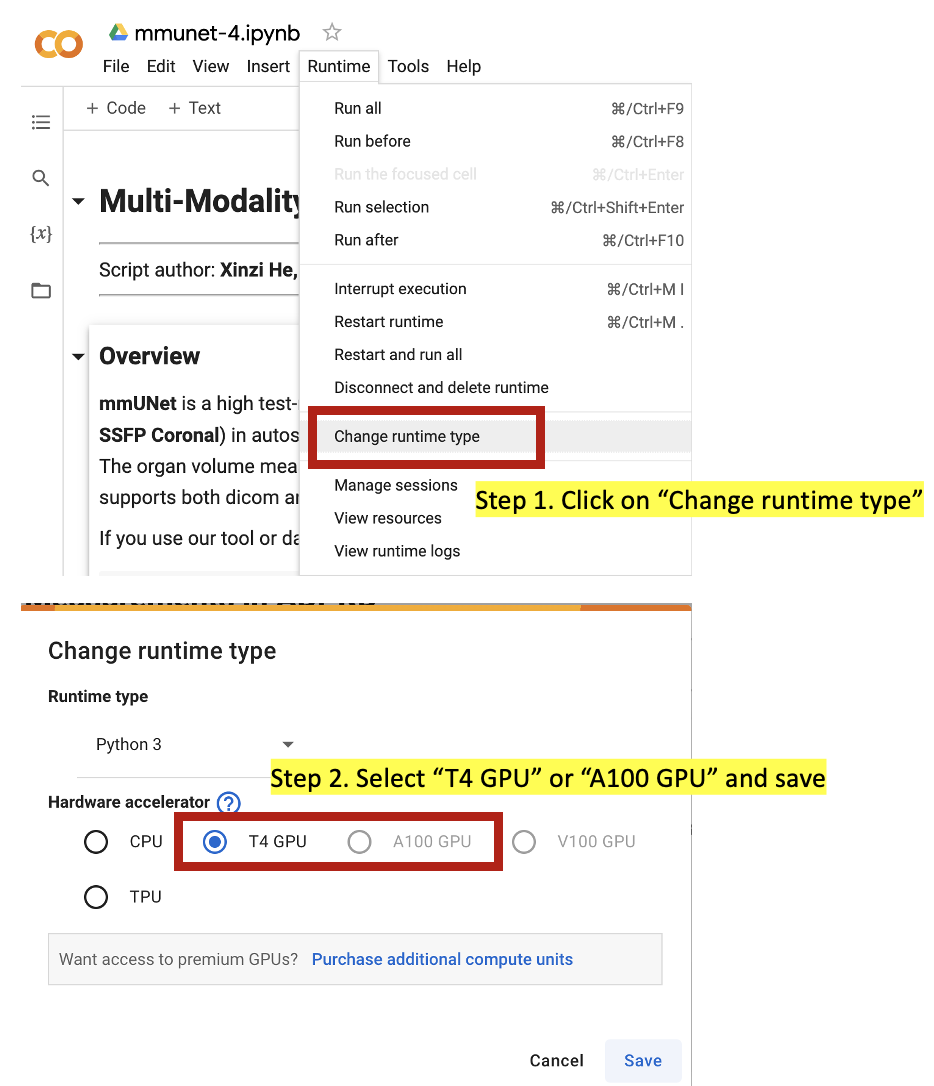


##**2. Install or import the required packages.**

In [2]:
#@title Preparing
%%capture
!pip install nnunet==1.7.1
!pip install ipyfilechooser
!pip install dicom2nifti

import tempfile
import os
import shutil
import glob
import contextlib
from ipyfilechooser import FileChooser
from tqdm import notebook as tqdm
from nnunet.inference.predict import predict_from_folder,predict_cases
from google.colab import drive
import time
import dicom2nifti

os.makedirs('/content/model_checkpoint',exist_ok=True)
os.makedirs('/content/test_data',exist_ok=True)

!gdown 1xWE1tT7JUuRO2N7SrNo8uEDzJdUwLAsH
!unzip -o /content/model_checkpoint.zip -d /content/model_checkpoint
!gdown 16Xirt3XxICb6TKyxWnW5FAFOaztPrxnp
!unzip -o /content/test_data.zip -d /content/test_data
!rm -rf model_checkpoint.zip
!rm -rf test_data.zip

## **3. Upload your images to Google Drive**
- This notebook will request access to your Google Drive files. <font color='red'>For privacy and safety reasons, it's crucial to anonymize your MRI images before uploading them to your Google Drive.</font>

- To anonymize your MRI, consider using ITK-SNAP. This tool can **convert your DICOM images to the NiFTI** format, effectively removing any patient health information. To do this:
  1. Load your images into ITK-SNAP.
  2. Click on "File > Save Image > Main Image".
  3. In the window that appears, choose your filename, specify the directory, and select 'NiFTI' as the file format.
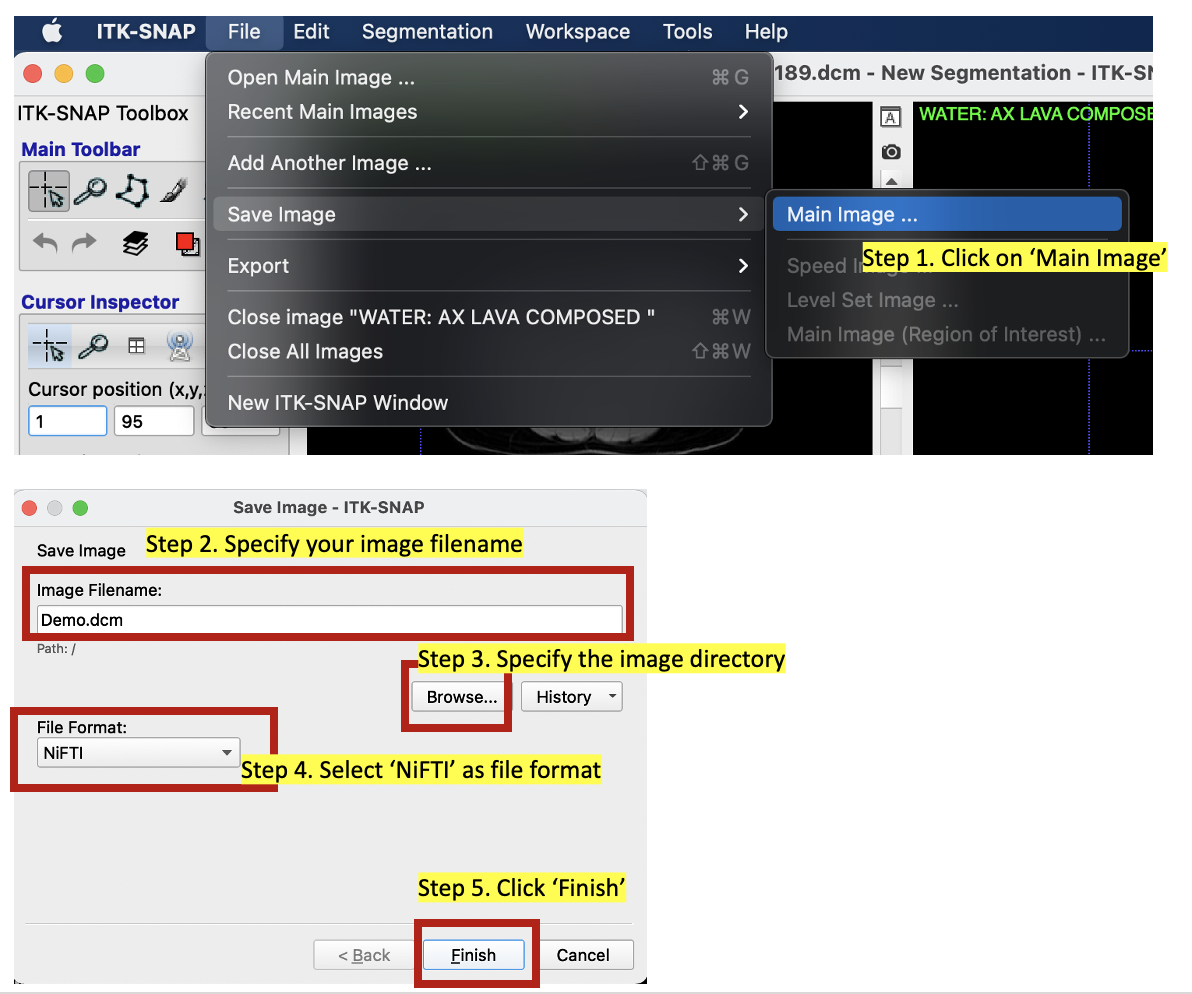
- If you're unfamiliar with ITK-SNAP or other imaging software, you may upload your MRI directly. <font color='red'>However, please be aware that while we can convert it to the NiFTI format for you, there may be associated risks.</font>
- If you don't have an MRI but wish to test our algorithm, simply leave the input folder field empty. The model will then execute segmentation using our provided demo data.


##**4. Specify  directories**
- **Input Folder**: This should be the directory containing your MRI files, whether in DICOM or NiFTI format.The folder can either contain individual DICOM images or multiple sub-folders with DICOM images.
- **Output Folder**: This should be the directory where you'd like to save the segmentation results.

In [3]:
#@title Select input folder and output folder
drive.mount('/content/drive')
fc_input = FileChooser('/content/drive')
fc_input.title = '<b>Please Select folder before you move forward</b>'
display(fc_input)
fc_output = FileChooser('/content/drive/MyDrive')
fc_output.title ='<b>Please select output folder. The output file name is adpkd_segmentation.zip</b>'
display(fc_output)


Mounted at /content/drive


FileChooser(path='/content/drive', filename='', title='<b>Please Select folder before you move forward</b>', s…

FileChooser(path='/content/drive/MyDrive', filename='', title='<b>Please select output folder. The output file…

##**5. Segmentation and reporting**

In [ ]:
#@title Preprocess selected images
%%capture

assert fc_input.selected_path is not None
assert fc_output.selected_path is not None

if os.path.isdir(fc_input.selected_path):
    user_input_path = fc_input.selected_path
elif os.path.isfile(fc_input.selected_path):
    user_input_path = os.path.dirname(fc_input.selected_path)
else:
    print("It is not file or dir" )

if os.path.isdir(fc_output.selected_path):
    final_output_path = fc_output.selected_path
elif os.path.isfile(fc_output.selected_path):
    final_output_path = os.path.dirname(fc_output.selected_path)
else:
    print("It is not file or dir" )
os.makedirs('/content/images',exist_ok=True)
dicom2nifti.convert_directory(user_input_path, '/content/images', compression=True, reorient=True)
nii_gz_file_path = glob.glob(os.path.join(user_input_path,'*.nii*'))
for i in nii_gz_file_path:
  shutil.copy2(i, os.path.join('/content/images',os.path.basename(i)))

In [ ]:
#@title Execute segmentation

base_path=os.getcwd()
with tempfile.TemporaryDirectory(dir=base_path):
  input_folder = os.path.join(base_path,'image_input_folder')
  os.makedirs(input_folder,exist_ok=True)
  output_folder = os.path.join(base_path,'seg_output_folder')
  os.makedirs(output_folder,exist_ok=True)
  nii_file_list = glob.glob('/content/images/*.nii.gz')
  if len(nii_file_list) ==0:
    print('There is no dicom files and nifti files, mmUNet will run on our test data')
    nii_file_list = glob.glob('/content/test_data/*.nii.gz')
  # for ind,file_path in enumerate(nii_file_list):
  #   shutil.copy(file_path,os.path.join(input_input_folder, 'ADPKD_{0:03d}_0000.nii.gz'.format(ind)))
  #   print(os.path.join(input_input_folder, 'ADPKD_{0:03d}_0000.nii.gz'.format(ind)))
  output_path_list = [os.path.join(output_folder,os.path.basename(i)) for i in nii_file_list]
  input_output_pair = dict(zip(nii_file_list,output_path_list))
  for input_path, output_path in tqdm.tqdm(input_output_pair.items()):
    with contextlib.redirect_stdout(None):
      predict_cases('/content/model_checkpoint',[[input_path]], [output_path], num_threads_preprocessing=6, num_threads_nifti_save=2,
                                      do_tta=True, mixed_precision=True, overwrite_existing=True,
                                      all_in_gpu=None,
                                      step_size=0.5, checkpoint_name='model_final_checkpoint',
                                      segmentation_export_kwargs=None,
                                      disable_postprocessing=True,folds='all',save_npz=False);
  shutil.make_archive('/content/adpkd_segmentation','zip',output_folder)
  shutil.copy2('/content/adpkd_segmentation.zip',os.path.join(final_output_path,'adpkd_segmentation.zip'))


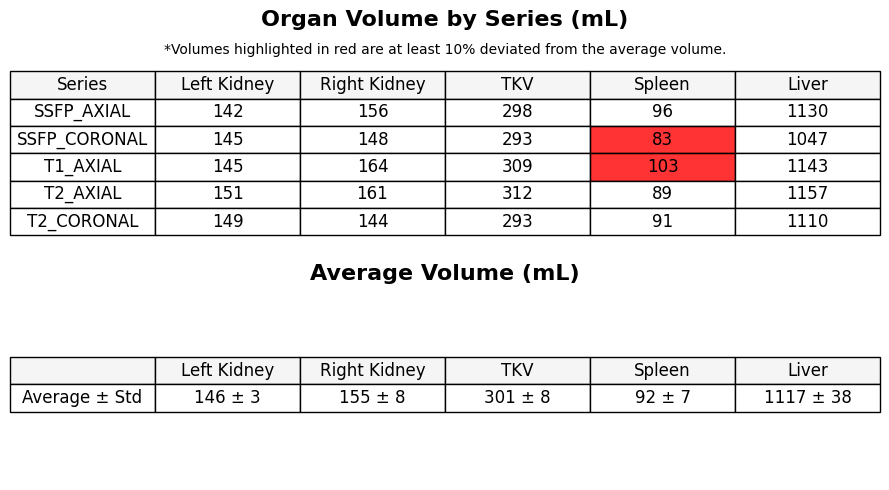

In [9]:
#@title Generate an organ volume summary table
%matplotlib inline

import SimpleITK as sitk
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Extract the series names
series_names = ([os.path.basename(i).replace('.nii.gz', '') for i in output_path_list])

# Extract the volume data
volume_data = []
for path in output_path_list:
    volume_size = []
    seg_sitk = sitk.ReadImage(path)
    shape_stats = sitk.LabelShapeStatisticsImageFilter()
    shape_stats.Execute(seg_sitk)

    for i in range(1, 5):
        try:
            volume_size.append(round(shape_stats.GetPhysicalSize(i) / 1000))
        except:
            volume_size.append(0)

    # Compute the TKV (sum of left and right kidney volumes)
    tkv = volume_size[0] + volume_size[1]
    volume_size.insert(2, tkv)

    volume_data.append([series_names.pop(0)] + volume_size)

#Sort the volume data table based on series name by alphabetical order
volume_data = sorted(volume_data, key=lambda x: x[0])

# Compute average volume and standard deviation for each organ
average_volumes = ['Average ± Std']
for i in range(1, 6): # Including TKV
    mean_val = round(np.mean([row[i] for row in volume_data]))
    std_val = round(np.std([row[i] for row in volume_data]))
    average_volumes.append(f"{mean_val} ± {std_val}")

# Compute average volume for each organ
average_volumes_numeric = [np.mean([row[i] for row in volume_data]) for i in range(1, 6)]
thresholds_5percent = [0.05 * avg for avg in average_volumes_numeric]
thresholds_10percent = [0.1 * avg for avg in average_volumes_numeric]

# Configure plot with two subplots (main volume data and average data)
desired_fontsize = 16
reference_fontsize = 12  # the font size at which you know the best figsize
reference_figsize = (7, 4)  # the best figsize for the reference fontsize

fig, axes = plt.subplots(2, 1, figsize=(9, 5))

# Configure titles
axes[0].set_title('Organ Volume by Series (mL)\n', fontsize=16, fontweight='bold')
axes[1].set_title('Average Volume (mL)', fontsize=16, fontweight='bold')

# column labels for the main table
main_column_labels = ['Series', 'Left Kidney', 'Right Kidney','TKV', 'Spleen', 'Liver']
avg_column_labels = ['', 'Left Kidney', 'Right Kidney', 'TKV','Spleen', 'Liver']

# Draw main volume table
volume_table = axes[0].table(cellText=volume_data , colLabels=main_column_labels, loc='center', cellLoc='center', colColours=['#f5f5f5'] * len(main_column_labels))
volume_table.auto_set_font_size(False)
volume_table.set_fontsize(12)
volume_table.scale(1, 1.5)

# Highlight cells based on the 5% threshold criteria
for i in range(len(volume_data)):
    for j in range(len(volume_data[0])-1):
        if abs(volume_data[i][j+1] - average_volumes_numeric[j]) > thresholds_10percent[j]:
          volume_table[i+1, j+1].set_facecolor((1, 0, 0, 0.8))
          #volume_table[i+1, j+1].set_text_props(color='black')
        #elif abs(volume_data[i][j+1] - average_volumes_numeric[j]) > thresholds_5percent[j]:
          #volume_table[i+1, j+1].set_facecolor((1, 0, 0, 0.2))
          #volume_table[i+1, j+1].set_text_props(color='black')

# Adding a note below the first table
fig.text(0.5, 0.89, '*Volumes highlighted in red are at least 10% deviated from the average volume.',
         ha='center', va='center', color='black',fontsize = 10)

# Draw average and standard deviation table
avg_table = axes[1].table(cellText=[average_volumes], colLabels=avg_column_labels, loc='center', cellLoc='center', colColours=['#f5f5f5'] * len(avg_column_labels))
avg_table.auto_set_font_size(False)
avg_table.set_fontsize(12)
avg_table.scale(1, 1.5)

# Turn off axes
for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

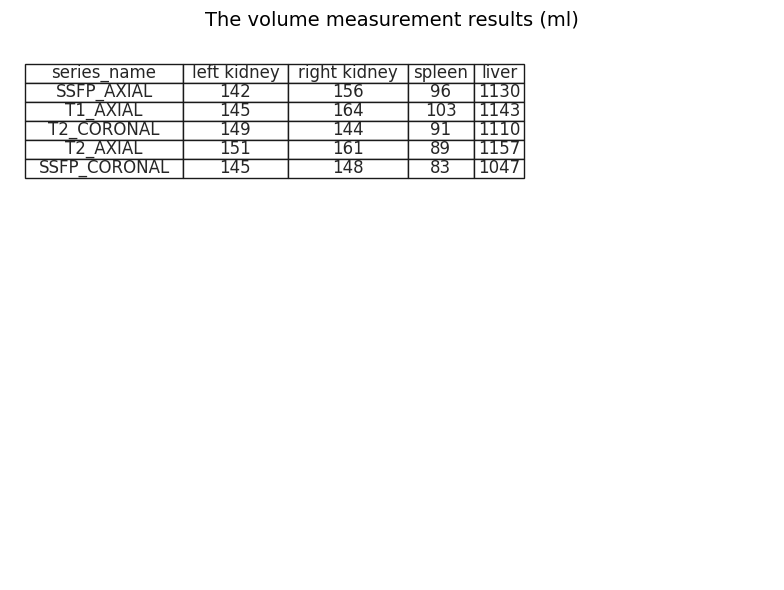

In [ ]:
#@title Generate an organ volume summary table
%matplotlib inline

import SimpleITK as sitk
import seaborn as sns
import matplotlib.pyplot as plt

row_label  = [os.path.basename(i).replace('.nii.gz','') for i in output_path_list]
volume_list = []
for path in output_path_list:
  volume_size = []
  seg_sitk = sitk.ReadImage(path)
  shape_stats = sitk.LabelShapeStatisticsImageFilter()
  shape_stats.Execute(seg_sitk)

  for i in range(1,5):
    try:
      volume_size.append(round(shape_stats.GetPhysicalSize(i)/1000))
    except:
      volume_size.append(0)

  volume_list.append(volume_size)

fig, (ax_distplot) = plt.subplots(1, 1, figsize=(8, 6))
fig.suptitle('The volume measurement results (ml)', fontsize=14)

sns.set(font_scale=1)  # crazy big
volume_list_for_plot= volume_list
for row, data in enumerate(volume_list_for_plot):
    volume_list_for_plot[row].insert(0, row_label[row])
unique_classes_for_plot = ['left kidney', 'right kidney','spleen','liver']
unique_classes_for_plot.insert(0,'series_name')

selected_volume_table = plt.table(cellText=volume_list_for_plot, colLabels=unique_classes_for_plot, loc='upper left', cellLoc='center')
selected_volume_table.auto_set_column_width(col=list(range(len(unique_classes_for_plot))))
plt.axis('off')
plt.tight_layout()
plt.show()